In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
! pip install category-encoders

In [56]:
! pip install scikeras

In [57]:
!pip install keras-tuner --upgrade

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from category_encoders import TargetEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from keras_tuner import RandomSearch
from tensorflow.keras.utils import plot_model
from keras_tuner.engine.hyperparameters import HyperParameters
import keras_tuner as kt
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [207]:
data = pd.read_csv('/content/drive/MyDrive/H4TF - Business 2/100000 Sales Records.csv')

In [208]:
data['Order Date'] = pd.to_datetime(data['Order Date'], format='%m/%d/%Y')
data['Ship Date'] = pd.to_datetime(data['Ship Date'], format='%m/%d/%Y')
data = data.sort_values(by='Order Date').reset_index(drop=True)

In [209]:
def create_features(data):
    data['Order Year'] = data['Order Date'].dt.year
    data['Order Month'] = data['Order Date'].dt.month
    data['Order Day'] = data['Order Date'].dt.day

    data['Ship Year'] = data['Ship Date'].dt.year
    data['Ship Month'] = data['Ship Date'].dt.month
    data['Ship Day'] = data['Ship Date'].dt.day

    data['Shipping Time'] = (data['Ship Date'] - data['Order Date']).dt.days
    data['On Time Delivery'] = np.where(data['Shipping Time'] <= 4, 1, 0)
    data['Order DayOfWeek'] = data['Order Date'].dt.dayofweek
    data['Ship DayOfWeek'] = data['Ship Date'].dt.dayofweek
    return data

data = create_features(data)

In [210]:
daily_revenue = data.groupby(['Order Date'])['Total Revenue'].sum().reset_index()
daily_revenue.columns = ['Order Date', 'Daily Total Revenue']

daily_order_count = data.groupby(['Order Date'])['Order ID'].count().reset_index()
daily_order_count.columns = ['Order Date', 'Daily Order Count']

daily_units_sold = data.groupby(['Order Date'])['Units Sold'].sum().reset_index()
daily_units_sold.columns = ['Order Date', 'Daily Units Sold']

daily_avg_price = data.groupby(['Order Date'])['Unit Price'].mean().reset_index()
daily_avg_price.columns = ['Order Date', 'Daily Avg Price']


In [211]:
daily_shipping_time = data.groupby(['Order Date'])['Shipping Time'].mean().reset_index()
daily_shipping_time.columns = ['Order Date', 'Average Shipping Time']

daily_on_time_delivery = data.groupby(['Order Date'])['On Time Delivery'].mean().reset_index()
daily_on_time_delivery.columns = ['Order Date', 'On Time Delivery Rate']

In [212]:
# Gộp các đặc trưng tổng hợp vào dataframe chính
daily_data = daily_revenue
daily_data = daily_data.merge(daily_order_count, on='Order Date')
daily_data = daily_data.merge(daily_units_sold, on='Order Date')
daily_data = daily_data.merge(daily_avg_price, on='Order Date')
daily_data = daily_data.merge(daily_shipping_time, on='Order Date')
daily_data = daily_data.merge(daily_on_time_delivery, on='Order Date')

In [213]:
# Đếm số lượng đơn hàng mỗi ngày theo từng giá trị của các biến phân loại
region_count = data.groupby(['Order Date', 'Region'])['Order ID'].count().unstack().fillna(0).reset_index()
region_count.columns = ['Order Date'] + [f'Count_{col}' for col in region_count.columns[1:]]

country_count = data.groupby(['Order Date', 'Country'])['Order ID'].count().unstack().fillna(0).reset_index()
country_count.columns = ['Order Date'] + [f'Count_{col}' for col in country_count.columns[1:]]

item_type_count = data.groupby(['Order Date', 'Item Type'])['Order ID'].count().unstack().fillna(0).reset_index()
item_type_count.columns = ['Order Date'] + [f'Count_{col}' for col in item_type_count.columns[1:]]

sales_channel_count = data.groupby(['Order Date', 'Sales Channel'])['Order ID'].count().unstack().fillna(0).reset_index()
sales_channel_count.columns = ['Order Date'] + [f'Count_{col}' for col in sales_channel_count.columns[1:]]

order_priority_count = data.groupby(['Order Date', 'Order Priority'])['Order ID'].count().unstack().fillna(0).reset_index()
order_priority_count.columns = ['Order Date'] + [f'Count_{col}' for col in order_priority_count.columns[1:]]

# Tổng doanh thu mỗi ngày theo từng giá trị của các biến phân loại
region_revenue = data.groupby(['Order Date', 'Region'])['Total Revenue'].sum().unstack().fillna(0).reset_index()
region_revenue.columns = ['Order Date'] + [f'Revenue_{col}' for col in region_revenue.columns[1:]]

country_revenue = data.groupby(['Order Date', 'Country'])['Total Revenue'].sum().unstack().fillna(0).reset_index()
country_revenue.columns = ['Order Date'] + [f'Revenue_{col}' for col in country_revenue.columns[1:]]

item_type_revenue = data.groupby(['Order Date', 'Item Type'])['Total Revenue'].sum().unstack().fillna(0).reset_index()
item_type_revenue.columns = ['Order Date'] + [f'Revenue_{col}' for col in item_type_revenue.columns[1:]]

sales_channel_revenue = data.groupby(['Order Date', 'Sales Channel'])['Total Revenue'].sum().unstack().fillna(0).reset_index()
sales_channel_revenue.columns = ['Order Date'] + [f'Revenue_{col}' for col in sales_channel_revenue.columns[1:]]

order_priority_revenue = data.groupby(['Order Date', 'Order Priority'])['Total Revenue'].sum().unstack().fillna(0).reset_index()
order_priority_revenue.columns = ['Order Date'] + [f'Revenue_{col}' for col in order_priority_revenue.columns[1:]]


In [214]:
daily_data = daily_data.merge(region_count, on='Order Date')
daily_data = daily_data.merge(country_count, on='Order Date')
daily_data = daily_data.merge(item_type_count, on='Order Date')
daily_data = daily_data.merge(sales_channel_count, on='Order Date')
daily_data = daily_data.merge(order_priority_count, on='Order Date')

daily_data = daily_data.merge(region_revenue, on='Order Date')
daily_data = daily_data.merge(country_revenue, on='Order Date')
daily_data = daily_data.merge(item_type_revenue, on='Order Date')
daily_data = daily_data.merge(sales_channel_revenue, on='Order Date')
daily_data = daily_data.merge(order_priority_revenue, on='Order Date')


In [215]:
daily_data.set_index('Order Date', inplace=True)

In [216]:
daily_data

,Daily Total Revenue,Daily Order Count,Daily Units Sold,Daily Avg Price,Average Shipping Time,On Time Delivery Rate,Count_Asia,Count_Australia and Oceania,Count_Central America and the Caribbean,Count_Europe,...,Revenue_Office Supplies,Revenue_Personal Care,Revenue_Snacks,Revenue_Vegetables,Revenue_Offline,Revenue_Online,Revenue_C,Revenue_H,Revenue_L,Revenue_M
Order Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,47119220.30,35,187660,248.646571,27.371429,0.028571,7.0,1.0,4.0,10.0,...,4705643.46,1428640.40,2597064.18,5490544.34,23165537.56,23953682.74,13741638.99,9236759.03,11985441.46,12155380.82
2010-01-02,38397582.10,34,152706,249.351176,29.352941,0.029412,5.0,5.0,1.0,7.0,...,10304095.83,804223.20,68050.68,5129119.58,21052081.73,17345500.37,4264248.81,6492726.79,10588484.46,17052122.04
2010-01-03,65138561.36,43,214970,294.543023,25.906977,0.093023,12.0,3.0,5.0,9.0,...,21486673.95,827761.44,2302889.94,0.00,37337028.14,27801533.22,20914384.60,10469036.70,17423219.62,16331920.44
2010-01-04,70553636.16,46,246684,287.126087,25.673913,0.021739,10.0,3.0,3.0,12.0,...,31537449.09,2200661.98,5069012.76,1006936.16,37285486.06,33268150.10,28994164.64,8050618.36,26333038.64,7175814.52
2010-01-05,48762396.14,32,164530,268.966250,25.531250,0.187500,6.0,3.0,1.0,9.0,...,13574472.45,1059465.99,2373229.32,2825306.34,32581715.43,16180680.71,6897390.81,15086083.02,13422047.65,13356874.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-24,53949237.29,49,227967,267.277959,25.367347,0.081633,8.0,5.0,7.0,9.0,...,3913772.10,1543552.78,5004471.42,4624419.02,21258914.27,32690323.02,18843380.25,9056852.86,10543798.85,15505205.33
2017-07-25,43917353.04,28,142925,282.682857,21.357143,0.178571,4.0,7.0,2.0,7.0,...,16636461.87,1557038.23,279831.72,2678487.16,19046338.01,24871015.03,11995537.48,7993368.79,17321172.26,6607274.51
2017-07-26,58720600.44,42,222418,260.646190,28.404762,0.023810,11.0,1.0,4.0,13.0,...,9135825.09,2357583.58,4968462.54,856573.60,16702926.87,42017673.57,11045909.25,22495871.26,18095051.73,7083768.20


In [217]:
daily_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2766 entries, 2010-01-01 to 2017-07-28
Columns: 426 entries, Daily Total Revenue to Revenue_M
dtypes: float64(422), int64(4)
memory usage: 9.0 MB


In [218]:
train_data = daily_data['2010-01-01':'2016-12-31']
test_data = daily_data['2017-01-01':'2017-12-31']

In [219]:
feature_columns = train_data.columns.drop(['Daily Total Revenue'])
X_train = train_data[feature_columns].values
y_train = train_data['Daily Total Revenue'].values
X_test = test_data[feature_columns].values
y_test = test_data['Daily Total Revenue'].values

In [220]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_features = scaler.fit_transform(X_train)
scaled_test_features = scaler.transform(X_test)


In [221]:
target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_target = target_scaler.fit_transform(y_train.reshape(-1, 1))
scaled_test_target = target_scaler.transform(y_test.reshape(-1, 1))

In [224]:
def create_dataset(features, target, time_step=1):
    X, y = [], []
    for i in range(len(features) - time_step):
        X.append(features[i:(i + time_step), :])
        y.append(target[i + time_step])
    return np.array(X), np.array(y)

time_step = 30
X_train, y_train = create_dataset(scaled_train_features, scaled_train_target, time_step)
X_test, y_test = create_dataset(scaled_test_features, scaled_test_target, time_step)

In [225]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2527, 30, 425), (2527, 1), (179, 30, 425), (179, 1))

In [226]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(32))
model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


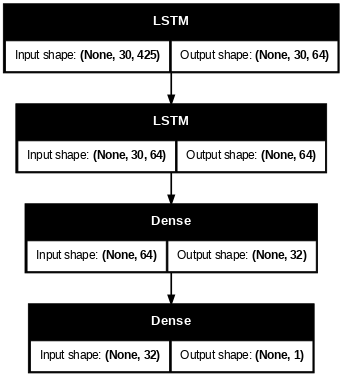

In [227]:
plot_model(
    model, dpi=60,
    show_shapes=True
)

In [228]:
initial_learning_rate = 0.001
lr_schedule = LearningRateScheduler(lambda epoch: initial_learning_rate * np.exp(-epoch / 100), verbose=1)
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(loss='mean_absolute_error', optimizer=optimizer)

In [229]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [230]:
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')
# y_train = y_train.astype('float32')
# y_test = y_test.astype('float32')

In [245]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping, lr_schedule]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.1179 - val_loss: 0.1163 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.000990049833749168.
Epoch 2/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - loss: 0.1189 - val_loss: 0.1167 - learning_rate: 9.9005e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009801986733067552.
Epoch 3/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.1119 - val_loss: 0.1161 - learning_rate: 9.8020e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009704455335485082.
Epoch 4/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.1117 - val_loss: 0.1188 - learning_rate: 9.7045e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0009607894391523232.
Epoch 5/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - loss: 0.1101 - val_loss: 0.1178 - learning_rate: 9.6079e-04

Epoch 6: LearningRateScheduler setting learning ra

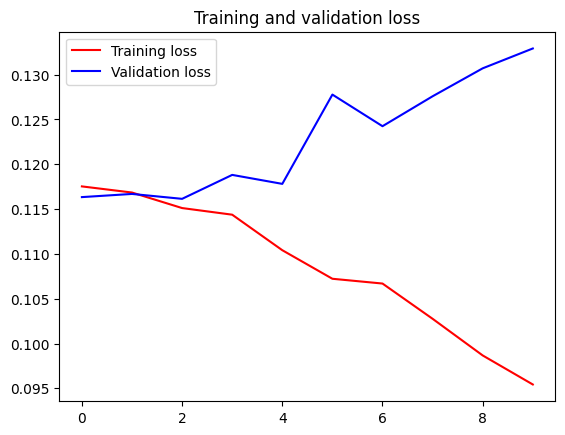

<Figure size 640x480 with 0 Axes>

In [246]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [247]:
train_pred=model.predict(X_train)
test_pred=model.predict(X_test)

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [248]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [249]:
def evaluate_model(y_true_train, y_pred_train, y_true_test, y_pred_test):
    # Calculate evaluation metrics for training data
    train_mae = mean_absolute_error(y_true_train, y_pred_train)
    train_mse = mean_squared_error(y_true_train, y_pred_train)
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(y_true_train, y_pred_train)

    # Calculate evaluation metrics for testing data
    test_mae = mean_absolute_error(y_true_test, y_pred_test)
    test_mse = mean_squared_error(y_true_test, y_pred_test)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_true_test, y_pred_test)

    # Print evaluation metrics
    print(f"Training Data: MAE: {train_mae}, MSE: {train_mse}, RMSE: {train_rmse}, R-squared: {train_r2}")
    print(f"Testing Data: MAE: {test_mae}, MSE: {test_mse}, RMSE: {test_rmse}, R-squared: {test_r2}")

    # Return metrics as a dictionary
    metrics_dict = {
        'train_mae': train_mae,
        'train_mse': train_mse,
        'train_rmse': train_rmse,
        'train_r2': train_r2,
        'test_mae': test_mae,
        'test_mse': test_mse,
        'test_rmse': test_rmse,
        'test_r2': test_r2
    }

    return metrics_dict

In [250]:
evaluate_model(y_train, train_pred, y_test, test_pred)

Training Data: MAE: 0.11615660607459101, MSE: 0.02163201921793738, RMSE: 0.1470782758191616, R-squared: 0.04443722306928066
Testing Data: MAE: 0.11633713553023398, MSE: 0.021636555397565857, RMSE: 0.14709369598173083, R-squared: -0.02614772201423876


{'train_mae': 0.11615660607459101,
 'train_mse': 0.02163201921793738,
 'train_rmse': 0.1470782758191616,
 'train_r2': 0.04443722306928066,
 'test_mae': 0.11633713553023398,
 'test_mse': 0.021636555397565857,
 'test_rmse': 0.14709369598173083,
 'test_r2': -0.02614772201423876}

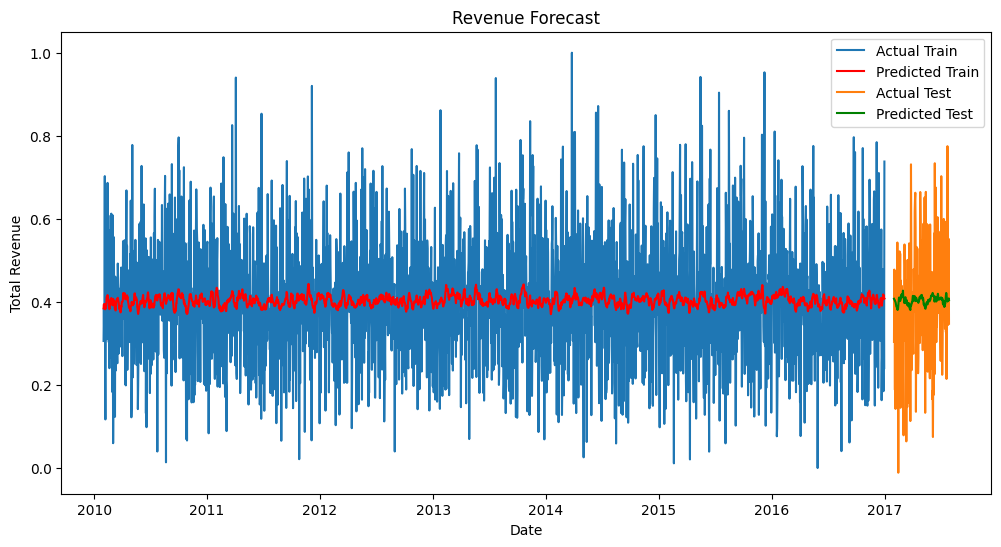

In [244]:
plt.figure(figsize=(12,6))
plt.plot(train_data.index[time_step:len(train_pred)+time_step], y_train, label='Actual Train')
plt.plot(train_data.index[time_step:len(train_pred)+time_step], train_pred, label='Predicted Train', color='red')
plt.plot(test_data.index[time_step:len(test_pred)+time_step], y_test, label='Actual Test')
plt.plot(test_data.index[time_step:len(test_pred)+time_step], test_pred, label='Predicted Test', color='green')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.title('Revenue Forecast')
plt.show()

In [261]:
def inverse_transform_predictions(predictions, original_data, scaler, target_col_index):
    dummy_data = np.zeros((predictions.shape[0], original_data.shape[1]))
    dummy_data[:, target_col_index] = predictions[:, 0]
    inversed = scaler.inverse_transform(dummy_data)
    return inversed[:, target_col_index]

In [262]:
train_predict_1 = inverse_transform_predictions(train_pred, scaled_train_features, scaler, train_data.columns.get_loc('Daily Total Revenue'))
test_predict_1 = inverse_transform_predictions(test_pred, scaled_test_features, scaler, test_data.columns.get_loc('Daily Total Revenue'))

# Inverse transform y_train và y_test để lấy giá trị thực
original_ytrain = inverse_transform_predictions(y_train.reshape(-1, 1), scaled_train_features, scaler, train_data.columns.get_loc('Daily Total Revenue'))
original_ytest = inverse_transform_predictions(y_test.reshape(-1, 1), scaled_test_features, scaler, test_data.columns.get_loc('Daily Total Revenue'))

In [263]:
evaluate_model(original_ytrain, train_predict_1, original_ytest, test_predict_1)

Training Data: MAE: 1.4017238020658115e+17, MSE: 2.08151761878198e+34, RMSE: 1.4427465538971075e+17, R-squared: -16.83831749580555
Testing Data: MAE: 1.391909184149642e+17, MSE: 2.0460954240272047e+34, RMSE: 1.4304179193603542e+17, R-squared: -17.82605325508903


{'train_mae': 1.4017238020658115e+17,
 'train_mse': 2.08151761878198e+34,
 'train_rmse': 1.4427465538971075e+17,
 'train_r2': -16.83831749580555,
 'test_mae': 1.391909184149642e+17,
 'test_mse': 2.0460954240272047e+34,
 'test_rmse': 1.4304179193603542e+17,
 'test_r2': -17.82605325508903}

In [264]:
# Chuyển đổi các giá trị dự đoán trên tập huấn luyện về giá trị gốc
train_pred_original = target_scaler.inverse_transform(train_pred.reshape(-1, 1)).ravel()

# Chuyển đổi các giá trị dự đoán trên tập kiểm tra về giá trị gốc
test_pred_original = target_scaler.inverse_transform(test_pred.reshape(-1, 1)).ravel()

# Chuyển đổi giá trị thực tế của y_train và y_test về giá trị gốc
y_train_original = target_scaler.inverse_transform(y_train.reshape(-1, 1)).ravel()
y_test_original = target_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()

In [265]:
evaluate_model(y_train_original, train_pred_original, y_test_original, test_pred_original)

Training Data: MAE: 2.9676108706009628e+23, MSE: 9.329730565318742e+46, RMSE: 3.0544607650645543e+23, R-squared: -16.83831749580556
Testing Data: MAE: 2.9468321931069405e+23, MSE: 9.170962015817977e+46, RMSE: 3.028359624585227e+23, R-squared: -17.826053255089036


{'train_mae': 2.9676108706009628e+23,
 'train_mse': 9.329730565318742e+46,
 'train_rmse': 3.0544607650645543e+23,
 'train_r2': -16.83831749580556,
 'test_mae': 2.9468321931069405e+23,
 'test_mse': 9.170962015817977e+46,
 'test_rmse': 3.028359624585227e+23,
 'test_r2': -17.826053255089036}